Dataset Link: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [35]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix


In [39]:
train_dir = r'C:\Users\ainle\Desktop\Pneumonia_Detection\chest_xray\train'
test_dir = r'C:\Users\ainle\Desktop\Pneumonia_Detection\chest_xray\test'
val_dir = r'C:\Users\ainle\Desktop\Pneumonia_Detection\chest_xray\val'

labels = ['NORMAL', 'PNEUMONIA']
img_size = 150

def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized, class_num])
            except Exception as e:
                pass
    return np.array(data, dtype=object)

train = get_data(train_dir)
test = get_data(test_dir)
val = get_data(val_dir)


In [40]:
def prepare(data):
    x, y = [], []
    for img, label in data:
        x.append(img)
        y.append(label)
    x = np.array(x).reshape(-1, img_size, img_size, 1) / 255.0
    y = np.array(y)
    return x, y

x_train, y_train = prepare(train)
x_test, y_test = prepare(test)
x_val, y_val = prepare(val)


In [41]:
weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(weights))


In [43]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 1)),
    BatchNormalization(),
    MaxPool2D(),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPool2D(),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPool2D(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 148, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,801 (18.42 MB)

 Trainable params: 4,828,353 (18.42 MB)

 Non-trainable params: 448 (1.75 KB)

In [44]:
lr = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1)
early = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(x_train, y_train, epochs=15, batch_size=32, validation_data=(x_val, y_val),
                    class_weight=class_weights, callbacks=[lr, early])


Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 109s 650ms/step - accuracy: 0.8579 - loss: 1.3186 - val_accuracy: 0.5000 - val_loss: 44.5848 - learning_rate: 0.0010
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 108s 664ms/step - accuracy: 0.9381 - loss: 0.1643 - val_accuracy: 0.5000 - val_loss: 44.7566 - learning_rate: 0.0010
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 108s 664ms/step - accuracy: 0.9527 - loss: 0.1504 - val_accuracy: 0.5000 - val_loss: 6.4065 - learning_rate: 0.0010
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 652ms/step - accuracy: 0.9540 - loss: 0.1418 - val_accuracy: 0.6250 - val_loss: 3.4209 - learning_rate: 0.0010
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 102s 623ms/step - accuracy: 0.9709 - loss: 0.0733 - val_accuracy: 0.7500 - val_loss: 1.1514 - learning_rate: 0.0010
Epoch 6/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 104s 635ms/step - accuracy: 0.9645 - loss: 0.0899 - val_accuracy: 0.6250 - val_loss: 1.1749 - learning_rate: 0.0010
Epoch 7/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 102s 625ms/step - accu

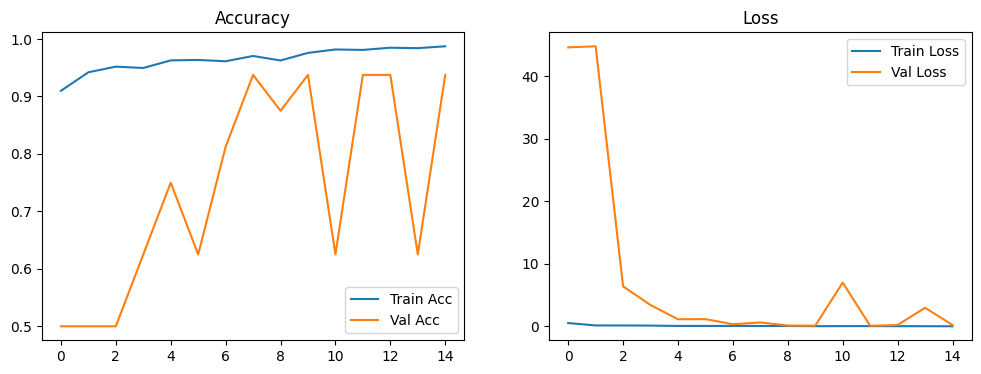

In [45]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.show()


In [46]:
loss, acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {acc:.2f}")

y_pred = (model.predict(x_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred, target_names=labels))


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.6747 - loss: 1.7352
Test Accuracy: 0.80
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step
              precision    recall  f1-score   support

      NORMAL       0.94      0.51      0.66       234
   PNEUMONIA       0.77      0.98      0.86       390

    accuracy                           0.80       624
   macro avg       0.85      0.74      0.76       624
weighted avg       0.83      0.80      0.79       624



In [ ]:
model.save("models/cnn_model.h5")

In [54]:
def predict_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_size, img_size))
    img = img.reshape(1, img_size, img_size, 1) / 255.0
    pred = model.predict(img)[0][0]
    
    # Correct class logic: 'NORMAL' = 0, 'PNEUMONIA' = 1
    label = "Normal" if pred < 0.5 else "Pneumonia"
    confidence = 1 - pred if pred < 0.5 else pred
    print(f"Prediction: {label} (Confidence: {confidence:.2f})")




In [56]:
predict_image(r"C:\Users\ainle\Desktop\Pneumonia_Detection\images_test\NORMAL2-IM-0401-0001.jpeg")
predict_image(r"C:\Users\ainle\Desktop\Pneumonia_Detection\images_test\person630_bacteria_2512.jpeg")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Prediction: Normal (Confidence: 1.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Prediction: Pneumonia (Confidence: 1.00)
